In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchnet as tnt
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, CenterCrop, Scale
#import torch.nn.functional as F
from torchnet.meter import meter
from tqdm import tqdm
from matplotlib import pyplot as plt
import h5py
import math
from math import log10
import os
from os import listdir
from os.path import join
import skimage.io as io
import skimage.color as col
import skimage.transform as tr
import numpy as np
from PIL import Image

%matplotlib inline

In [3]:
class PSNRMeter(meter.Meter):
    def __init__(self):
        super(PSNRMeter, self).__init__()
        self.reset()

    def reset(self):
        self.n = 0
        self.sesum = 0.0

    def add(self, output, target):
        if not torch.is_tensor(output) and not torch.is_tensor(target):
            output = torch.from_numpy(output)
            target = torch.from_numpy(target)
        output = output.cpu()
        target = target.cpu()
        self.n += output.numel()
        self.sesum += torch.sum((output - target) ** 2)

    def value(self):
        mse = self.sesum / max(1, self.n)
        psnr = 10 * log10(1 / mse)
        return psnr

In [4]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in
               ['.png', '.jpg', '.jpeg', '.JPG', '.JPEG', '.PNG', '.bmp'])

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Scale(crop_size // upscale_factor)
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size)
    ])
'''
def lr_transform(image, upscale_factor):
    return tr.resize(image, (image.shape[0] // upscale_factor,image.shape[1] // upscale_factor))
'''

class DatasetFromFolderY(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolderY, self).__init__()
        self.image_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/target'
        self.image_filenames = [join(self.image_dir, x) for x in listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [join(self.target_dir, x) for x in listdir(self.target_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        #image = col.rgb2ycbcr(io.imread(self.image_filenames[index]))[:,:,0]
        #target = col.rgb2ycbcr(io.imread(self.target_filenames[index]))[:,:,0]
        image, _, _ = Image.open(self.image_filenames[index]).convert('YCbCr').split()
        target, _, _ = Image.open(self.target_filenames[index]).convert('YCbCr').split()

        #return transforms.ToTensor()(image), transforms.ToTensor()(target)
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)
    
class DatasetFromFolderCb(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolderCb, self).__init__()
        self.image_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/target'
        self.image_filenames = [join(self.image_dir, x) for x in listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [join(self.target_dir, x) for x in listdir(self.target_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        #image = col.rgb2ycbcr(io.imread(self.image_filenames[index]))[:,:,0]
        #target = col.rgb2ycbcr(io.imread(self.target_filenames[index]))[:,:,0]
        _, image, _ = Image.open(self.image_filenames[index]).convert('YCbCr').split()
        _, target, _ = Image.open(self.target_filenames[index]).convert('YCbCr').split()

        #return transforms.ToTensor()(image), transforms.ToTensor()(target)
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)
    
class DatasetFromFolderCr(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolderCr, self).__init__()
        self.image_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/target'
        self.image_filenames = [join(self.image_dir, x) for x in listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [join(self.target_dir, x) for x in listdir(self.target_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        #image = col.rgb2ycbcr(io.imread(self.image_filenames[index]))[:,:,0]
        #target = col.rgb2ycbcr(io.imread(self.target_filenames[index]))[:,:,0]
        _, _, image = Image.open(self.image_filenames[index]).convert('YCbCr').split()
        _, _, target = Image.open(self.target_filenames[index]).convert('YCbCr').split()

        #return transforms.ToTensor()(image), transforms.ToTensor()(target)
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)


def generate_dataset(data_type, upscale_factor, size):
    images_name = [x for x in listdir(data_type) if is_image_file(x)]
    crop_size = calculate_valid_crop_size(size, upscale_factor)
    lr_transform = input_transform(crop_size, upscale_factor)
    hr_transform = target_transform(crop_size)

    root = 'data/' + data_type
    if not os.path.exists(root):
        os.makedirs(root)
    path = root + '/SRF_' + str(upscale_factor)
    if not os.path.exists(path):
        os.makedirs(path)
    image_path = path + '/data'
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    target_path = path + '/target'
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    for image_name in tqdm(images_name, desc='generate ' + data_type + ' dataset with upscale factor = '
            + str(upscale_factor)):
        image = Image.open(data_type + '/' + image_name)
        target = image.copy()
        image = lr_transform(image)
        target = hr_transform(target)

        image.save(image_path + '/' + image_name)
        target.save(target_path + '/' + image_name)

UPSCALE_FACTOR = 3

generate_dataset(data_type='Train', upscale_factor=UPSCALE_FACTOR, size = 128)
generate_dataset(data_type='Test/Set14', upscale_factor=UPSCALE_FACTOR, size = 128)
generate_dataset(data_type='Test/Set5', upscale_factor=UPSCALE_FACTOR, size = 256)

/usr/local/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
generate Train dataset with upscale factor = 3: 100%|██████████| 91/91 [00:00<00:00, 735.95it/s]
generate Test/Set14 dataset with upscale factor = 3: 100%|██████████| 14/14 [00:00<00:00, 343.38it/s]
generate Test/Set5 dataset with upscale factor = 3: 100%|██████████| 5/5 [00:00<00:00, 328.23it/s]


In [5]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 1 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = torch.sigmoid(self.pixel_shuffle(self.conv3(x)))
        return x

In [6]:
def processorY(sample):
    data, target, training = sample
    data = Variable(data)
    target = Variable(target)
    if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()

    output = model_Y(data)
    loss = criterion(output, target)

    return loss, output

def processorCb(sample):
    data, target, training = sample
    data = Variable(data)
    target = Variable(target)
    if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()

    output = model_Cb(data)
    loss = criterion(output, target)

    return loss, output

def processorCr(sample):
    data, target, training = sample
    data = Variable(data)
    target = Variable(target)
    if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()

    output = model_Cr(data)
    loss = criterion(output, target)

    return loss, output

def on_sample(state):
    state['sample'].append(state['train'])


def reset_meters():
    meter_psnr.reset()
    meter_loss.reset()


def on_forward(state):
    meter_psnr.add(state['output'].data, state['sample'][1])
    #print(state['loss'].data)
    meter_loss.add(state['loss'].data)


def on_start_epoch(state):
    reset_meters()
    state['iterator'] = tqdm(state['iterator'])


def on_end_epochY(state):

    #train_loss_logger.log(state['epoch'], meter_loss.value()[0])
    #train_psnr_logger.log(state['epoch'], meter_psnr.value())
    
    train_loss.append(meter_loss.value()[0])
    train_psnr.append(meter_psnr.value())
    
    print('[Epoch %d] Train Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))

    reset_meters()

    engine.test(processorY, val_loader)
    #val_loss_logger.log(state['epoch'], meter_loss.value()[0])
    #val_psnr_logger.log(state['epoch'], meter_psnr.value())
    val_loss.append(meter_loss.value()[0])
    val_psnr.append(meter_psnr.value())

    print('[Epoch %d] Val Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))
    scheduler.step()
    
def on_end_epochCb(state):

    #train_loss_logger.log(state['epoch'], meter_loss.value()[0])
    #train_psnr_logger.log(state['epoch'], meter_psnr.value())
    
    train_loss.append(meter_loss.value()[0])
    train_psnr.append(meter_psnr.value())
    
    print('[Epoch %d] Train Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))

    reset_meters()

    engine.test(processorCb, val_loader)
    #val_loss_logger.log(state['epoch'], meter_loss.value()[0])
    #val_psnr_logger.log(state['epoch'], meter_psnr.value())
    val_loss.append(meter_loss.value()[0])
    val_psnr.append(meter_psnr.value())

    print('[Epoch %d] Val Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))
    scheduler.step()
    
def on_end_epochCr(state):

    #train_loss_logger.log(state['epoch'], meter_loss.value()[0])
    #train_psnr_logger.log(state['epoch'], meter_psnr.value())
    
    train_loss.append(meter_loss.value()[0])
    train_psnr.append(meter_psnr.value())
    
    print('[Epoch %d] Train Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))

    reset_meters()

    engine.test(processorCr, val_loader)
    #val_loss_logger.log(state['epoch'], meter_loss.value()[0])
    #val_psnr_logger.log(state['epoch'], meter_psnr.value())
    val_loss.append(meter_loss.value()[0])
    val_psnr.append(meter_psnr.value())

    print('[Epoch %d] Val Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))
    scheduler.step()

    #torch.save(model.state_dict(), 'epochs/epoch_%d_%d.pt' % (UPSCALE_FACTOR, state['epoch']))


UPSCALE_FACTOR = 3
NUM_EPOCHS = 100

train_loss = []
train_psnr = []
val_loss = []
val_psnr = []

train_set = DatasetFromFolderY('data/Train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())
val_set = DatasetFromFolderY('data/Test/Set14', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=8, shuffle=False)

model_Y = Net(upscale_factor=UPSCALE_FACTOR)
criterion = nn.MSELoss()
if torch.cuda.is_available():
    model_Y = model_Y.cuda()
    criterion = criterion.cuda()

print('# parameters:', sum(param.numel() for param in model_Y.parameters()))

optimizer = optim.Adam(model_Y.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_psnr = PSNRMeter()

engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epochY

engine.train(processorY, train_loader, maxepoch=NUM_EPOCHS, optimizer=optimizer)


 17%|█▋        | 2/12 [00:00<00:00, 16.77it/s]

# parameters: 22729


 25%|██▌       | 3/12 [00:00<00:00, 20.60it/s]

[Epoch 1] Train Loss: 0.0757 (PSNR: 11.07 db)
[Epoch 1] Val Loss: 0.0314 (PSNR: 15.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.87it/s]

[Epoch 2] Train Loss: 0.0162 (PSNR: 17.79 db)
[Epoch 2] Val Loss: 0.0151 (PSNR: 18.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.06it/s]

[Epoch 3] Train Loss: 0.0096 (PSNR: 20.15 db)
[Epoch 3] Val Loss: 0.0092 (PSNR: 20.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.57it/s]

[Epoch 4] Train Loss: 0.0079 (PSNR: 21.25 db)
[Epoch 4] Val Loss: 0.0075 (PSNR: 21.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.22it/s]

[Epoch 5] Train Loss: 0.0062 (PSNR: 21.97 db)
[Epoch 5] Val Loss: 0.0065 (PSNR: 21.80 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.08it/s]

[Epoch 6] Train Loss: 0.0057 (PSNR: 22.46 db)
[Epoch 6] Val Loss: 0.0057 (PSNR: 22.33 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.82it/s]

[Epoch 7] Train Loss: 0.0075 (PSNR: 21.27 db)
[Epoch 7] Val Loss: 0.0084 (PSNR: 20.67 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.13it/s]

[Epoch 8] Train Loss: 0.0057 (PSNR: 22.33 db)
[Epoch 8] Val Loss: 0.0099 (PSNR: 19.99 db)


 25%|██▌       | 3/12 [00:00<00:00, 19.41it/s]

[Epoch 9] Train Loss: 0.0058 (PSNR: 22.31 db)
[Epoch 9] Val Loss: 0.0050 (PSNR: 22.92 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.87it/s]

[Epoch 10] Train Loss: 0.0042 (PSNR: 23.82 db)
[Epoch 10] Val Loss: 0.0044 (PSNR: 23.41 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.88it/s]

[Epoch 11] Train Loss: 0.0039 (PSNR: 24.17 db)
[Epoch 11] Val Loss: 0.0044 (PSNR: 23.43 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.41it/s]

[Epoch 12] Train Loss: 0.0035 (PSNR: 24.50 db)
[Epoch 12] Val Loss: 0.0040 (PSNR: 23.83 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.82it/s]

[Epoch 13] Train Loss: 0.0033 (PSNR: 24.73 db)
[Epoch 13] Val Loss: 0.0039 (PSNR: 23.95 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.47it/s]

[Epoch 14] Train Loss: 0.0032 (PSNR: 24.89 db)
[Epoch 14] Val Loss: 0.0038 (PSNR: 24.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.86it/s]

[Epoch 15] Train Loss: 0.0031 (PSNR: 25.05 db)
[Epoch 15] Val Loss: 0.0036 (PSNR: 24.26 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.90it/s]

[Epoch 16] Train Loss: 0.0031 (PSNR: 25.17 db)
[Epoch 16] Val Loss: 0.0036 (PSNR: 24.35 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.52it/s]

[Epoch 17] Train Loss: 0.0031 (PSNR: 25.27 db)
[Epoch 17] Val Loss: 0.0035 (PSNR: 24.42 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.36it/s]

[Epoch 18] Train Loss: 0.0030 (PSNR: 25.25 db)
[Epoch 18] Val Loss: 0.0035 (PSNR: 24.41 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.22it/s]

[Epoch 19] Train Loss: 0.0035 (PSNR: 24.72 db)
[Epoch 19] Val Loss: 0.0036 (PSNR: 24.25 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.34it/s]

[Epoch 20] Train Loss: 0.0055 (PSNR: 22.91 db)
[Epoch 20] Val Loss: 0.0044 (PSNR: 23.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.94it/s]

[Epoch 21] Train Loss: 0.0073 (PSNR: 21.44 db)
[Epoch 21] Val Loss: 0.0094 (PSNR: 20.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.93it/s]

[Epoch 22] Train Loss: 0.0090 (PSNR: 20.34 db)
[Epoch 22] Val Loss: 0.0067 (PSNR: 21.66 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.33it/s]

[Epoch 23] Train Loss: 0.0057 (PSNR: 22.41 db)
[Epoch 23] Val Loss: 0.0048 (PSNR: 23.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.73it/s]

[Epoch 24] Train Loss: 0.0036 (PSNR: 24.36 db)
[Epoch 24] Val Loss: 0.0039 (PSNR: 24.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.65it/s]

[Epoch 25] Train Loss: 0.0031 (PSNR: 25.14 db)
[Epoch 25] Val Loss: 0.0035 (PSNR: 24.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.17it/s]

[Epoch 26] Train Loss: 0.0028 (PSNR: 25.43 db)
[Epoch 26] Val Loss: 0.0033 (PSNR: 24.67 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.96it/s]

[Epoch 27] Train Loss: 0.0027 (PSNR: 25.64 db)
[Epoch 27] Val Loss: 0.0032 (PSNR: 24.80 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.53it/s]

[Epoch 28] Train Loss: 0.0027 (PSNR: 25.66 db)
[Epoch 28] Val Loss: 0.0032 (PSNR: 24.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.44it/s]

[Epoch 29] Train Loss: 0.0026 (PSNR: 25.78 db)
[Epoch 29] Val Loss: 0.0031 (PSNR: 24.93 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.14it/s]

[Epoch 30] Train Loss: 0.0026 (PSNR: 25.85 db)
[Epoch 30] Val Loss: 0.0031 (PSNR: 24.97 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.63it/s]

[Epoch 31] Train Loss: 0.0025 (PSNR: 25.90 db)
[Epoch 31] Val Loss: 0.0031 (PSNR: 24.99 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.02it/s]

[Epoch 32] Train Loss: 0.0026 (PSNR: 25.91 db)
[Epoch 32] Val Loss: 0.0031 (PSNR: 25.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.45it/s]

[Epoch 33] Train Loss: 0.0026 (PSNR: 25.92 db)
[Epoch 33] Val Loss: 0.0031 (PSNR: 25.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.27it/s]

[Epoch 34] Train Loss: 0.0027 (PSNR: 25.92 db)
[Epoch 34] Val Loss: 0.0031 (PSNR: 25.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.64it/s]

[Epoch 35] Train Loss: 0.0026 (PSNR: 25.92 db)
[Epoch 35] Val Loss: 0.0030 (PSNR: 25.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.69it/s]

[Epoch 36] Train Loss: 0.0025 (PSNR: 25.93 db)
[Epoch 36] Val Loss: 0.0030 (PSNR: 25.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.66it/s]

[Epoch 37] Train Loss: 0.0025 (PSNR: 25.93 db)
[Epoch 37] Val Loss: 0.0030 (PSNR: 25.02 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.47it/s]

[Epoch 38] Train Loss: 0.0026 (PSNR: 25.94 db)
[Epoch 38] Val Loss: 0.0030 (PSNR: 25.02 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.18it/s]

[Epoch 39] Train Loss: 0.0025 (PSNR: 25.94 db)
[Epoch 39] Val Loss: 0.0030 (PSNR: 25.03 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.39it/s]

[Epoch 40] Train Loss: 0.0026 (PSNR: 25.95 db)
[Epoch 40] Val Loss: 0.0030 (PSNR: 25.03 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.83it/s]

[Epoch 41] Train Loss: 0.0026 (PSNR: 25.95 db)
[Epoch 41] Val Loss: 0.0030 (PSNR: 25.03 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.25it/s]

[Epoch 42] Train Loss: 0.0025 (PSNR: 25.96 db)
[Epoch 42] Val Loss: 0.0030 (PSNR: 25.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.20it/s]

[Epoch 43] Train Loss: 0.0025 (PSNR: 25.96 db)
[Epoch 43] Val Loss: 0.0030 (PSNR: 25.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.79it/s]

[Epoch 44] Train Loss: 0.0025 (PSNR: 25.96 db)
[Epoch 44] Val Loss: 0.0030 (PSNR: 25.05 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 45] Train Loss: 0.0026 (PSNR: 25.97 db)
[Epoch 45] Val Loss: 0.0030 (PSNR: 25.05 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.86it/s]

[Epoch 46] Train Loss: 0.0026 (PSNR: 25.97 db)
[Epoch 46] Val Loss: 0.0030 (PSNR: 25.05 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.94it/s]

[Epoch 47] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 47] Val Loss: 0.0030 (PSNR: 25.06 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.95it/s]

[Epoch 48] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 48] Val Loss: 0.0030 (PSNR: 25.06 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.03it/s]

[Epoch 49] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 49] Val Loss: 0.0030 (PSNR: 25.07 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.71it/s]

[Epoch 50] Train Loss: 0.0025 (PSNR: 25.99 db)
[Epoch 50] Val Loss: 0.0030 (PSNR: 25.07 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.21it/s]

[Epoch 51] Train Loss: 0.0026 (PSNR: 25.99 db)
[Epoch 51] Val Loss: 0.0030 (PSNR: 25.07 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.61it/s]

[Epoch 52] Train Loss: 0.0027 (PSNR: 26.00 db)
[Epoch 52] Val Loss: 0.0030 (PSNR: 25.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.50it/s]

[Epoch 53] Train Loss: 0.0026 (PSNR: 26.00 db)
[Epoch 53] Val Loss: 0.0030 (PSNR: 25.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.13it/s]

[Epoch 54] Train Loss: 0.0024 (PSNR: 26.01 db)
[Epoch 54] Val Loss: 0.0030 (PSNR: 25.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.83it/s]

[Epoch 55] Train Loss: 0.0026 (PSNR: 26.01 db)
[Epoch 55] Val Loss: 0.0030 (PSNR: 25.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.91it/s]

[Epoch 56] Train Loss: 0.0024 (PSNR: 26.01 db)
[Epoch 56] Val Loss: 0.0030 (PSNR: 25.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.90it/s]

[Epoch 57] Train Loss: 0.0026 (PSNR: 26.02 db)
[Epoch 57] Val Loss: 0.0030 (PSNR: 25.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.18it/s]

[Epoch 58] Train Loss: 0.0024 (PSNR: 26.02 db)
[Epoch 58] Val Loss: 0.0030 (PSNR: 25.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.10it/s]

[Epoch 59] Train Loss: 0.0024 (PSNR: 26.03 db)
[Epoch 59] Val Loss: 0.0030 (PSNR: 25.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.17it/s]

[Epoch 60] Train Loss: 0.0026 (PSNR: 26.03 db)
[Epoch 60] Val Loss: 0.0030 (PSNR: 25.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.56it/s]

[Epoch 61] Train Loss: 0.0025 (PSNR: 26.04 db)
[Epoch 61] Val Loss: 0.0030 (PSNR: 25.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.45it/s]

[Epoch 62] Train Loss: 0.0026 (PSNR: 26.04 db)
[Epoch 62] Val Loss: 0.0030 (PSNR: 25.12 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.04it/s]

[Epoch 63] Train Loss: 0.0026 (PSNR: 26.04 db)
[Epoch 63] Val Loss: 0.0030 (PSNR: 25.12 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.31it/s]

[Epoch 64] Train Loss: 0.0024 (PSNR: 26.05 db)
[Epoch 64] Val Loss: 0.0030 (PSNR: 25.12 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.16it/s]

[Epoch 65] Train Loss: 0.0024 (PSNR: 26.05 db)
[Epoch 65] Val Loss: 0.0030 (PSNR: 25.13 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.27it/s]

[Epoch 66] Train Loss: 0.0025 (PSNR: 26.06 db)
[Epoch 66] Val Loss: 0.0030 (PSNR: 25.13 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.34it/s]

[Epoch 67] Train Loss: 0.0024 (PSNR: 26.06 db)
[Epoch 67] Val Loss: 0.0030 (PSNR: 25.13 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.98it/s]

[Epoch 68] Train Loss: 0.0025 (PSNR: 26.07 db)
[Epoch 68] Val Loss: 0.0030 (PSNR: 25.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.22it/s]

[Epoch 69] Train Loss: 0.0024 (PSNR: 26.07 db)
[Epoch 69] Val Loss: 0.0030 (PSNR: 25.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.76it/s]

[Epoch 70] Train Loss: 0.0026 (PSNR: 26.07 db)
[Epoch 70] Val Loss: 0.0030 (PSNR: 25.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.03it/s]

[Epoch 71] Train Loss: 0.0025 (PSNR: 26.08 db)
[Epoch 71] Val Loss: 0.0030 (PSNR: 25.15 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.05it/s]

[Epoch 72] Train Loss: 0.0024 (PSNR: 26.08 db)
[Epoch 72] Val Loss: 0.0029 (PSNR: 25.15 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.82it/s]

[Epoch 73] Train Loss: 0.0024 (PSNR: 26.09 db)
[Epoch 73] Val Loss: 0.0029 (PSNR: 25.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.86it/s]

[Epoch 74] Train Loss: 0.0024 (PSNR: 26.09 db)
[Epoch 74] Val Loss: 0.0029 (PSNR: 25.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.90it/s]

[Epoch 75] Train Loss: 0.0024 (PSNR: 26.09 db)
[Epoch 75] Val Loss: 0.0029 (PSNR: 25.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.09it/s]

[Epoch 76] Train Loss: 0.0024 (PSNR: 26.10 db)
[Epoch 76] Val Loss: 0.0029 (PSNR: 25.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.02it/s]

[Epoch 77] Train Loss: 0.0025 (PSNR: 26.10 db)
[Epoch 77] Val Loss: 0.0029 (PSNR: 25.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.03it/s]

[Epoch 78] Train Loss: 0.0025 (PSNR: 26.11 db)
[Epoch 78] Val Loss: 0.0029 (PSNR: 25.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.03it/s]

[Epoch 79] Train Loss: 0.0025 (PSNR: 26.11 db)
[Epoch 79] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.14it/s]

[Epoch 80] Train Loss: 0.0024 (PSNR: 26.11 db)
[Epoch 80] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.08it/s]

[Epoch 81] Train Loss: 0.0025 (PSNR: 26.12 db)
[Epoch 81] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.02it/s]

[Epoch 82] Train Loss: 0.0025 (PSNR: 26.12 db)
[Epoch 82] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.89it/s]

[Epoch 83] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 83] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.95it/s]

[Epoch 84] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 84] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.97it/s]

[Epoch 85] Train Loss: 0.0025 (PSNR: 26.12 db)
[Epoch 85] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.04it/s]

[Epoch 86] Train Loss: 0.0025 (PSNR: 26.12 db)
[Epoch 86] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.29it/s]

[Epoch 87] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 87] Val Loss: 0.0029 (PSNR: 25.18 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.47it/s]

[Epoch 88] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 88] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.37it/s]

[Epoch 89] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 89] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.90it/s]

[Epoch 90] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 90] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.92it/s]

[Epoch 91] Train Loss: 0.0025 (PSNR: 26.12 db)
[Epoch 91] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.18it/s]

[Epoch 92] Train Loss: 0.0026 (PSNR: 26.12 db)
[Epoch 92] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.07it/s]

[Epoch 93] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 93] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.31it/s]

[Epoch 94] Train Loss: 0.0026 (PSNR: 26.12 db)
[Epoch 94] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.07it/s]

[Epoch 95] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 95] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.25it/s]

[Epoch 96] Train Loss: 0.0024 (PSNR: 26.13 db)
[Epoch 96] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.30it/s]

[Epoch 97] Train Loss: 0.0025 (PSNR: 26.13 db)
[Epoch 97] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.04it/s]

[Epoch 98] Train Loss: 0.0024 (PSNR: 26.13 db)
[Epoch 98] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.37it/s]

[Epoch 99] Train Loss: 0.0024 (PSNR: 26.13 db)
[Epoch 99] Val Loss: 0.0029 (PSNR: 25.19 db)


100%|██████████| 12/12 [00:00<00:00, 23.38it/s]

[Epoch 100] Train Loss: 0.0023 (PSNR: 26.13 db)
[Epoch 100] Val Loss: 0.0029 (PSNR: 25.19 db)


{'network': <function __main__.processorY(sample)>,
 'iterator': 100%|██████████| 12/12 [00:00<00:00, 21.51it/s],
 'maxepoch': 100,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.01
     lr: 0.0001
     weight_decay: 0
 ),
 'epoch': 100,
 't': 1200,
 'train': True,
 'sample': [tensor([[[[0.3059, 0.3098, 0.3137,  ..., 0.5294, 0.5412, 0.5412],
            [0.2902, 0.3020, 0.3059,  ..., 0.5490, 0.5569, 0.5608],
            [0.2863, 0.2941, 0.2980,  ..., 0.5686, 0.5765, 0.5804],
            ...,
            [0.2784, 0.2863, 0.2824,  ..., 0.4824, 0.4824, 0.4902],
            [0.2902, 0.2941, 0.2980,  ..., 0.4706, 0.4784, 0.4745],
            [0.3059, 0.3137, 0.3098,  ..., 0.4745, 0.4745, 0.4745]]],
  
  
          [[[0.5843, 0.5961, 0.6000,  ..., 0.6510, 0.6980, 0.6431],
            [0.6196, 0.5882, 0.5961,  ..., 0.6588, 0.6784, 0.6314],
            [0.6745, 0.6157, 0.5922,  ..., 0.7059, 0.6510, 0.6196],
            ..

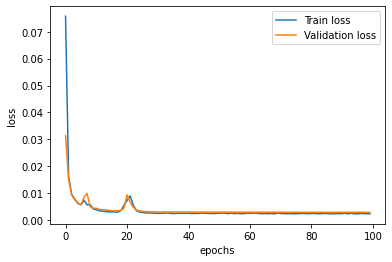

In [7]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

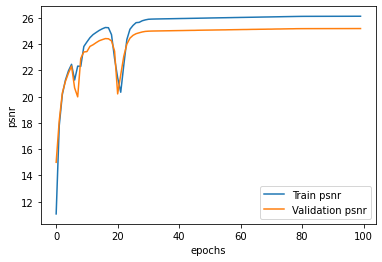

In [8]:
plt.plot(train_psnr, label = 'Train psnr')
plt.plot(val_psnr, label = 'Validation psnr')
plt.xlabel('epochs')
plt.ylabel('psnr')
plt.legend()
plt.show()

In [9]:
train_loss = []
train_psnr = []
val_loss = []
val_psnr = []

train_set = DatasetFromFolderCb('data/Train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())
val_set = DatasetFromFolderCb('data/Test/Set14', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=8, shuffle=False)
model_Cb = Net(upscale_factor=UPSCALE_FACTOR)
if torch.cuda.is_available():
    model_Cb = model_Cb.cuda()
    criterion = criterion.cuda()
optimizer = optim.Adam(model_Cb.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_psnr = PSNRMeter()
engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epochCb

engine.train(processorCb, train_loader, maxepoch=NUM_EPOCHS, optimizer=optimizer)

 25%|██▌       | 3/12 [00:00<00:00, 21.06it/s]

[Epoch 1] Train Loss: 0.0531 (PSNR: 12.57 db)
[Epoch 1] Val Loss: 0.0259 (PSNR: 15.89 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.36it/s]

[Epoch 2] Train Loss: 0.0089 (PSNR: 20.38 db)
[Epoch 2] Val Loss: 0.0040 (PSNR: 24.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.62it/s]

[Epoch 3] Train Loss: 0.0033 (PSNR: 24.83 db)
[Epoch 3] Val Loss: 0.0024 (PSNR: 26.20 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.90it/s]

[Epoch 4] Train Loss: 0.0024 (PSNR: 26.21 db)
[Epoch 4] Val Loss: 0.0015 (PSNR: 28.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.28it/s]

[Epoch 5] Train Loss: 0.0026 (PSNR: 25.65 db)
[Epoch 5] Val Loss: 0.0015 (PSNR: 28.32 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.60it/s]

[Epoch 6] Train Loss: 0.0020 (PSNR: 27.10 db)
[Epoch 6] Val Loss: 0.0024 (PSNR: 26.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.52it/s]

[Epoch 7] Train Loss: 0.0021 (PSNR: 26.84 db)
[Epoch 7] Val Loss: 0.0007 (PSNR: 31.41 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.74it/s]

[Epoch 8] Train Loss: 0.0014 (PSNR: 28.32 db)
[Epoch 8] Val Loss: 0.0010 (PSNR: 30.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.78it/s]

[Epoch 9] Train Loss: 0.0011 (PSNR: 29.59 db)
[Epoch 9] Val Loss: 0.0007 (PSNR: 31.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.58it/s]

[Epoch 10] Train Loss: 0.0009 (PSNR: 30.57 db)
[Epoch 10] Val Loss: 0.0008 (PSNR: 31.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.14it/s]

[Epoch 11] Train Loss: 0.0008 (PSNR: 30.61 db)
[Epoch 11] Val Loss: 0.0005 (PSNR: 33.03 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.97it/s]

[Epoch 12] Train Loss: 0.0012 (PSNR: 29.59 db)
[Epoch 12] Val Loss: 0.0101 (PSNR: 19.95 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.65it/s]

[Epoch 13] Train Loss: 0.0042 (PSNR: 23.70 db)
[Epoch 13] Val Loss: 0.0009 (PSNR: 30.51 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.04it/s]

[Epoch 14] Train Loss: 0.0016 (PSNR: 28.11 db)
[Epoch 14] Val Loss: 0.0005 (PSNR: 32.57 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.28it/s]

[Epoch 15] Train Loss: 0.0013 (PSNR: 28.97 db)
[Epoch 15] Val Loss: 0.0006 (PSNR: 32.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.86it/s]

[Epoch 16] Train Loss: 0.0010 (PSNR: 29.92 db)
[Epoch 16] Val Loss: 0.0008 (PSNR: 30.72 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.01it/s]

[Epoch 17] Train Loss: 0.0007 (PSNR: 31.35 db)
[Epoch 17] Val Loss: 0.0003 (PSNR: 34.43 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.53it/s]

[Epoch 18] Train Loss: 0.0006 (PSNR: 32.18 db)
[Epoch 18] Val Loss: 0.0004 (PSNR: 34.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.51it/s]

[Epoch 19] Train Loss: 0.0006 (PSNR: 32.53 db)
[Epoch 19] Val Loss: 0.0003 (PSNR: 35.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.18it/s]

[Epoch 20] Train Loss: 0.0005 (PSNR: 33.37 db)
[Epoch 20] Val Loss: 0.0005 (PSNR: 32.56 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.15it/s]

[Epoch 21] Train Loss: 0.0005 (PSNR: 33.22 db)
[Epoch 21] Val Loss: 0.0003 (PSNR: 35.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.15it/s]

[Epoch 22] Train Loss: 0.0004 (PSNR: 34.08 db)
[Epoch 22] Val Loss: 0.0003 (PSNR: 35.71 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.89it/s]

[Epoch 23] Train Loss: 0.0003 (PSNR: 34.65 db)
[Epoch 23] Val Loss: 0.0003 (PSNR: 35.65 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.13it/s]

[Epoch 24] Train Loss: 0.0004 (PSNR: 34.94 db)
[Epoch 24] Val Loss: 0.0002 (PSNR: 36.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.16it/s]

[Epoch 25] Train Loss: 0.0003 (PSNR: 34.94 db)
[Epoch 25] Val Loss: 0.0003 (PSNR: 34.98 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.20it/s]

[Epoch 26] Train Loss: 0.0004 (PSNR: 34.30 db)
[Epoch 26] Val Loss: 0.0003 (PSNR: 34.90 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.14it/s]

[Epoch 27] Train Loss: 0.0004 (PSNR: 34.27 db)
[Epoch 27] Val Loss: 0.0003 (PSNR: 34.75 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.24it/s]

[Epoch 28] Train Loss: 0.0004 (PSNR: 34.34 db)
[Epoch 28] Val Loss: 0.0003 (PSNR: 35.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.27it/s]

[Epoch 29] Train Loss: 0.0004 (PSNR: 33.83 db)
[Epoch 29] Val Loss: 0.0003 (PSNR: 34.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.28it/s]

[Epoch 30] Train Loss: 0.0004 (PSNR: 33.89 db)
[Epoch 30] Val Loss: 0.0003 (PSNR: 35.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.07it/s]

[Epoch 31] Train Loss: 0.0003 (PSNR: 35.58 db)
[Epoch 31] Val Loss: 0.0002 (PSNR: 36.59 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.05it/s]

[Epoch 32] Train Loss: 0.0002 (PSNR: 36.02 db)
[Epoch 32] Val Loss: 0.0002 (PSNR: 36.74 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.89it/s]

[Epoch 33] Train Loss: 0.0002 (PSNR: 36.16 db)
[Epoch 33] Val Loss: 0.0002 (PSNR: 36.76 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.88it/s]

[Epoch 34] Train Loss: 0.0002 (PSNR: 36.19 db)
[Epoch 34] Val Loss: 0.0002 (PSNR: 36.77 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.43it/s]

[Epoch 35] Train Loss: 0.0002 (PSNR: 36.22 db)
[Epoch 35] Val Loss: 0.0002 (PSNR: 36.79 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.52it/s]

[Epoch 36] Train Loss: 0.0002 (PSNR: 36.23 db)
[Epoch 36] Val Loss: 0.0002 (PSNR: 36.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.76it/s]

[Epoch 37] Train Loss: 0.0002 (PSNR: 36.26 db)
[Epoch 37] Val Loss: 0.0002 (PSNR: 36.81 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.02it/s]

[Epoch 38] Train Loss: 0.0002 (PSNR: 36.27 db)
[Epoch 38] Val Loss: 0.0002 (PSNR: 36.82 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.20it/s]

[Epoch 39] Train Loss: 0.0002 (PSNR: 36.29 db)
[Epoch 39] Val Loss: 0.0002 (PSNR: 36.84 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.24it/s]

[Epoch 40] Train Loss: 0.0002 (PSNR: 36.31 db)
[Epoch 40] Val Loss: 0.0002 (PSNR: 36.84 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.06it/s]

[Epoch 41] Train Loss: 0.0002 (PSNR: 36.33 db)
[Epoch 41] Val Loss: 0.0002 (PSNR: 36.86 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.35it/s]

[Epoch 42] Train Loss: 0.0002 (PSNR: 36.34 db)
[Epoch 42] Val Loss: 0.0002 (PSNR: 36.85 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.70it/s]

[Epoch 43] Train Loss: 0.0002 (PSNR: 36.35 db)
[Epoch 43] Val Loss: 0.0002 (PSNR: 36.85 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.81it/s]

[Epoch 44] Train Loss: 0.0002 (PSNR: 36.38 db)
[Epoch 44] Val Loss: 0.0002 (PSNR: 36.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.43it/s]

[Epoch 45] Train Loss: 0.0002 (PSNR: 36.40 db)
[Epoch 45] Val Loss: 0.0002 (PSNR: 36.89 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.00it/s]

[Epoch 46] Train Loss: 0.0002 (PSNR: 36.41 db)
[Epoch 46] Val Loss: 0.0002 (PSNR: 36.90 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.82it/s]

[Epoch 47] Train Loss: 0.0002 (PSNR: 36.43 db)
[Epoch 47] Val Loss: 0.0002 (PSNR: 36.91 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.65it/s]

[Epoch 48] Train Loss: 0.0002 (PSNR: 36.45 db)
[Epoch 48] Val Loss: 0.0002 (PSNR: 36.92 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.94it/s]

[Epoch 49] Train Loss: 0.0002 (PSNR: 36.47 db)
[Epoch 49] Val Loss: 0.0002 (PSNR: 36.93 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.48it/s]

[Epoch 50] Train Loss: 0.0002 (PSNR: 36.48 db)
[Epoch 50] Val Loss: 0.0002 (PSNR: 36.94 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.06it/s]

[Epoch 51] Train Loss: 0.0002 (PSNR: 36.50 db)
[Epoch 51] Val Loss: 0.0002 (PSNR: 36.94 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.43it/s]

[Epoch 52] Train Loss: 0.0002 (PSNR: 36.52 db)
[Epoch 52] Val Loss: 0.0002 (PSNR: 36.94 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.59it/s]

[Epoch 53] Train Loss: 0.0002 (PSNR: 36.53 db)
[Epoch 53] Val Loss: 0.0002 (PSNR: 36.94 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.67it/s]

[Epoch 54] Train Loss: 0.0002 (PSNR: 36.55 db)
[Epoch 54] Val Loss: 0.0002 (PSNR: 36.97 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.49it/s]

[Epoch 55] Train Loss: 0.0002 (PSNR: 36.56 db)
[Epoch 55] Val Loss: 0.0002 (PSNR: 36.97 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.43it/s]

[Epoch 56] Train Loss: 0.0002 (PSNR: 36.57 db)
[Epoch 56] Val Loss: 0.0002 (PSNR: 36.98 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.60it/s]

[Epoch 57] Train Loss: 0.0002 (PSNR: 36.60 db)
[Epoch 57] Val Loss: 0.0002 (PSNR: 37.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.67it/s]

[Epoch 58] Train Loss: 0.0002 (PSNR: 36.61 db)
[Epoch 58] Val Loss: 0.0002 (PSNR: 37.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.57it/s]

[Epoch 59] Train Loss: 0.0002 (PSNR: 36.63 db)
[Epoch 59] Val Loss: 0.0002 (PSNR: 37.02 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.52it/s]

[Epoch 60] Train Loss: 0.0002 (PSNR: 36.65 db)
[Epoch 60] Val Loss: 0.0002 (PSNR: 36.96 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.61it/s]

[Epoch 61] Train Loss: 0.0002 (PSNR: 36.65 db)
[Epoch 61] Val Loss: 0.0002 (PSNR: 37.03 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.49it/s]

[Epoch 62] Train Loss: 0.0002 (PSNR: 36.68 db)
[Epoch 62] Val Loss: 0.0002 (PSNR: 37.05 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.63it/s]

[Epoch 63] Train Loss: 0.0002 (PSNR: 36.70 db)
[Epoch 63] Val Loss: 0.0002 (PSNR: 37.03 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.60it/s]

[Epoch 64] Train Loss: 0.0002 (PSNR: 36.72 db)
[Epoch 64] Val Loss: 0.0002 (PSNR: 37.05 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.38it/s]

[Epoch 65] Train Loss: 0.0002 (PSNR: 36.74 db)
[Epoch 65] Val Loss: 0.0002 (PSNR: 37.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.23it/s]

[Epoch 66] Train Loss: 0.0002 (PSNR: 36.75 db)
[Epoch 66] Val Loss: 0.0002 (PSNR: 37.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.55it/s]

[Epoch 67] Train Loss: 0.0002 (PSNR: 36.78 db)
[Epoch 67] Val Loss: 0.0002 (PSNR: 37.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.64it/s]

[Epoch 68] Train Loss: 0.0002 (PSNR: 36.79 db)
[Epoch 68] Val Loss: 0.0002 (PSNR: 37.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.71it/s]

[Epoch 69] Train Loss: 0.0002 (PSNR: 36.81 db)
[Epoch 69] Val Loss: 0.0002 (PSNR: 37.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.58it/s]

[Epoch 70] Train Loss: 0.0002 (PSNR: 36.83 db)
[Epoch 70] Val Loss: 0.0002 (PSNR: 37.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.55it/s]

[Epoch 71] Train Loss: 0.0002 (PSNR: 36.84 db)
[Epoch 71] Val Loss: 0.0002 (PSNR: 37.12 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.62it/s]

[Epoch 72] Train Loss: 0.0002 (PSNR: 36.86 db)
[Epoch 72] Val Loss: 0.0002 (PSNR: 37.13 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.51it/s]

[Epoch 73] Train Loss: 0.0002 (PSNR: 36.88 db)
[Epoch 73] Val Loss: 0.0002 (PSNR: 37.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.34it/s]

[Epoch 74] Train Loss: 0.0002 (PSNR: 36.89 db)
[Epoch 74] Val Loss: 0.0002 (PSNR: 37.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.54it/s]

[Epoch 75] Train Loss: 0.0002 (PSNR: 36.92 db)
[Epoch 75] Val Loss: 0.0002 (PSNR: 37.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.35it/s]

[Epoch 76] Train Loss: 0.0002 (PSNR: 36.93 db)
[Epoch 76] Val Loss: 0.0002 (PSNR: 37.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.48it/s]

[Epoch 77] Train Loss: 0.0002 (PSNR: 36.94 db)
[Epoch 77] Val Loss: 0.0002 (PSNR: 37.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.58it/s]

[Epoch 78] Train Loss: 0.0002 (PSNR: 36.96 db)
[Epoch 78] Val Loss: 0.0002 (PSNR: 37.20 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.66it/s]

[Epoch 79] Train Loss: 0.0002 (PSNR: 36.98 db)
[Epoch 79] Val Loss: 0.0002 (PSNR: 37.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.57it/s]

[Epoch 80] Train Loss: 0.0002 (PSNR: 37.00 db)
[Epoch 80] Val Loss: 0.0002 (PSNR: 37.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.03it/s]

[Epoch 81] Train Loss: 0.0002 (PSNR: 37.02 db)
[Epoch 81] Val Loss: 0.0002 (PSNR: 37.20 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.67it/s]

[Epoch 82] Train Loss: 0.0002 (PSNR: 37.03 db)
[Epoch 82] Val Loss: 0.0002 (PSNR: 37.22 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.91it/s]

[Epoch 83] Train Loss: 0.0002 (PSNR: 37.03 db)
[Epoch 83] Val Loss: 0.0002 (PSNR: 37.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.74it/s]

[Epoch 84] Train Loss: 0.0002 (PSNR: 37.03 db)
[Epoch 84] Val Loss: 0.0002 (PSNR: 37.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.39it/s]

[Epoch 85] Train Loss: 0.0002 (PSNR: 37.03 db)
[Epoch 85] Val Loss: 0.0002 (PSNR: 37.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.34it/s]

[Epoch 86] Train Loss: 0.0002 (PSNR: 37.03 db)
[Epoch 86] Val Loss: 0.0002 (PSNR: 37.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.94it/s]

[Epoch 87] Train Loss: 0.0002 (PSNR: 37.04 db)
[Epoch 87] Val Loss: 0.0002 (PSNR: 37.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.46it/s]

[Epoch 88] Train Loss: 0.0002 (PSNR: 37.04 db)
[Epoch 88] Val Loss: 0.0002 (PSNR: 37.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.59it/s]

[Epoch 89] Train Loss: 0.0002 (PSNR: 37.04 db)
[Epoch 89] Val Loss: 0.0002 (PSNR: 37.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.44it/s]

[Epoch 90] Train Loss: 0.0002 (PSNR: 37.04 db)
[Epoch 90] Val Loss: 0.0002 (PSNR: 37.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.07it/s]

[Epoch 91] Train Loss: 0.0002 (PSNR: 37.04 db)
[Epoch 91] Val Loss: 0.0002 (PSNR: 37.22 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.53it/s]

[Epoch 92] Train Loss: 0.0002 (PSNR: 37.05 db)
[Epoch 92] Val Loss: 0.0002 (PSNR: 37.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.37it/s]

[Epoch 93] Train Loss: 0.0002 (PSNR: 37.05 db)
[Epoch 93] Val Loss: 0.0002 (PSNR: 37.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.74it/s]

[Epoch 94] Train Loss: 0.0002 (PSNR: 37.05 db)
[Epoch 94] Val Loss: 0.0002 (PSNR: 37.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.95it/s]

[Epoch 95] Train Loss: 0.0002 (PSNR: 37.05 db)
[Epoch 95] Val Loss: 0.0002 (PSNR: 37.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.60it/s]

[Epoch 96] Train Loss: 0.0002 (PSNR: 37.05 db)
[Epoch 96] Val Loss: 0.0002 (PSNR: 37.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.52it/s]

[Epoch 97] Train Loss: 0.0002 (PSNR: 37.06 db)
[Epoch 97] Val Loss: 0.0002 (PSNR: 37.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.59it/s]

[Epoch 98] Train Loss: 0.0002 (PSNR: 37.06 db)
[Epoch 98] Val Loss: 0.0002 (PSNR: 37.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.69it/s]

[Epoch 99] Train Loss: 0.0002 (PSNR: 37.06 db)
[Epoch 99] Val Loss: 0.0002 (PSNR: 37.23 db)


100%|██████████| 12/12 [00:00<00:00, 23.69it/s]

[Epoch 100] Train Loss: 0.0002 (PSNR: 37.06 db)
[Epoch 100] Val Loss: 0.0002 (PSNR: 37.23 db)


{'network': <function __main__.processorCb(sample)>,
 'iterator': 100%|██████████| 12/12 [00:00<00:00, 21.65it/s],
 'maxepoch': 100,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.01
     lr: 0.0001
     weight_decay: 0
 ),
 'epoch': 100,
 't': 1200,
 'train': True,
 'sample': [tensor([[[[0.4706, 0.4706, 0.4745,  ..., 0.4627, 0.4667, 0.4706],
            [0.4706, 0.4745, 0.4745,  ..., 0.4667, 0.4667, 0.4706],
            [0.4824, 0.4784, 0.4784,  ..., 0.4745, 0.4745, 0.4706],
            ...,
            [0.4078, 0.4039, 0.4078,  ..., 0.4000, 0.4353, 0.4471],
            [0.4510, 0.4431, 0.4353,  ..., 0.3804, 0.4118, 0.4392],
            [0.4745, 0.4627, 0.4627,  ..., 0.4000, 0.4039, 0.4353]]],
  
  
          [[[0.4392, 0.4549, 0.4627,  ..., 0.3686, 0.3529, 0.3451],
            [0.4667, 0.4784, 0.4824,  ..., 0.4431, 0.4275, 0.4235],
            [0.4863, 0.4941, 0.4941,  ..., 0.4824, 0.4902, 0.4902],
            .

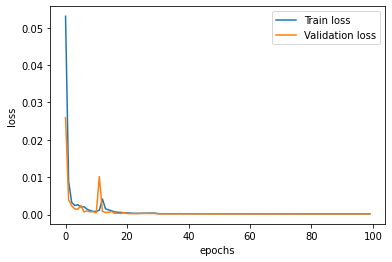

In [10]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

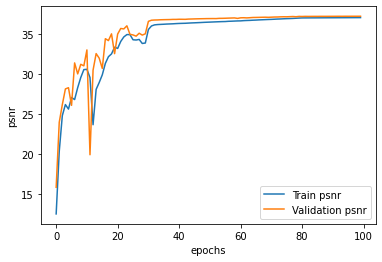

In [11]:
plt.plot(train_psnr, label = 'Train psnr')
plt.plot(val_psnr, label = 'Validation psnr')
plt.xlabel('epochs')
plt.ylabel('psnr')
plt.legend()
plt.show()

In [12]:
train_loss = []
train_psnr = []
val_loss = []
val_psnr = []

train_set = DatasetFromFolderCr('data/Train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())
val_set = DatasetFromFolderCr('data/Test/Set14', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=8, shuffle=False)
model_Cr = Net(upscale_factor=UPSCALE_FACTOR)
if torch.cuda.is_available():
    model_Cr = model_Cr.cuda()
    criterion = criterion.cuda()
optimizer = optim.Adam(model_Cr.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_psnr = PSNRMeter()
engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epochCr

engine.train(processorCr, train_loader, maxepoch=NUM_EPOCHS, optimizer=optimizer)

 25%|██▌       | 3/12 [00:00<00:00, 21.07it/s]

[Epoch 1] Train Loss: 0.0589 (PSNR: 12.18 db)
[Epoch 1] Val Loss: 0.0114 (PSNR: 19.31 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.96it/s]

[Epoch 2] Train Loss: 0.0231 (PSNR: 16.26 db)
[Epoch 2] Val Loss: 0.0151 (PSNR: 18.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.92it/s]

[Epoch 3] Train Loss: 0.0116 (PSNR: 19.28 db)
[Epoch 3] Val Loss: 0.0063 (PSNR: 21.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.69it/s]

[Epoch 4] Train Loss: 0.0058 (PSNR: 22.23 db)
[Epoch 4] Val Loss: 0.0024 (PSNR: 25.95 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.40it/s]

[Epoch 5] Train Loss: 0.0026 (PSNR: 25.78 db)
[Epoch 5] Val Loss: 0.0017 (PSNR: 27.65 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.23it/s]

[Epoch 6] Train Loss: 0.0017 (PSNR: 27.66 db)
[Epoch 6] Val Loss: 0.0014 (PSNR: 28.43 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.89it/s]

[Epoch 7] Train Loss: 0.0010 (PSNR: 29.71 db)
[Epoch 7] Val Loss: 0.0009 (PSNR: 30.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.89it/s]

[Epoch 8] Train Loss: 0.0010 (PSNR: 30.36 db)
[Epoch 8] Val Loss: 0.0009 (PSNR: 30.16 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.05it/s]

[Epoch 9] Train Loss: 0.0009 (PSNR: 30.32 db)
[Epoch 9] Val Loss: 0.0008 (PSNR: 30.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.03it/s]

[Epoch 10] Train Loss: 0.0008 (PSNR: 30.74 db)
[Epoch 10] Val Loss: 0.0008 (PSNR: 30.70 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.83it/s]

[Epoch 11] Train Loss: 0.0011 (PSNR: 29.94 db)
[Epoch 11] Val Loss: 0.0009 (PSNR: 30.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.84it/s]

[Epoch 12] Train Loss: 0.0008 (PSNR: 30.68 db)
[Epoch 12] Val Loss: 0.0010 (PSNR: 29.89 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.08it/s]

[Epoch 13] Train Loss: 0.0007 (PSNR: 31.52 db)
[Epoch 13] Val Loss: 0.0018 (PSNR: 27.34 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.79it/s]

[Epoch 14] Train Loss: 0.0008 (PSNR: 30.94 db)
[Epoch 14] Val Loss: 0.0008 (PSNR: 30.89 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.07it/s]

[Epoch 15] Train Loss: 0.0008 (PSNR: 31.36 db)
[Epoch 15] Val Loss: 0.0006 (PSNR: 31.55 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.93it/s]

[Epoch 16] Train Loss: 0.0006 (PSNR: 32.07 db)
[Epoch 16] Val Loss: 0.0007 (PSNR: 31.06 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.94it/s]

[Epoch 17] Train Loss: 0.0013 (PSNR: 28.61 db)
[Epoch 17] Val Loss: 0.0024 (PSNR: 26.02 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.77it/s]

[Epoch 18] Train Loss: 0.0042 (PSNR: 23.85 db)
[Epoch 18] Val Loss: 0.0010 (PSNR: 29.70 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.49it/s]

[Epoch 19] Train Loss: 0.0025 (PSNR: 25.75 db)
[Epoch 19] Val Loss: 0.0018 (PSNR: 27.44 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.45it/s]

[Epoch 20] Train Loss: 0.0011 (PSNR: 29.66 db)
[Epoch 20] Val Loss: 0.0007 (PSNR: 31.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.76it/s]

[Epoch 21] Train Loss: 0.0007 (PSNR: 31.57 db)
[Epoch 21] Val Loss: 0.0011 (PSNR: 29.35 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.23it/s]

[Epoch 22] Train Loss: 0.0009 (PSNR: 30.89 db)
[Epoch 22] Val Loss: 0.0009 (PSNR: 30.32 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.71it/s]

[Epoch 23] Train Loss: 0.0008 (PSNR: 31.01 db)
[Epoch 23] Val Loss: 0.0007 (PSNR: 31.31 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.18it/s]

[Epoch 24] Train Loss: 0.0009 (PSNR: 30.35 db)
[Epoch 24] Val Loss: 0.0027 (PSNR: 25.71 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.09it/s]

[Epoch 25] Train Loss: 0.0011 (PSNR: 29.56 db)
[Epoch 25] Val Loss: 0.0008 (PSNR: 30.65 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.67it/s]

[Epoch 26] Train Loss: 0.0007 (PSNR: 31.28 db)
[Epoch 26] Val Loss: 0.0007 (PSNR: 31.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.07it/s]

[Epoch 27] Train Loss: 0.0007 (PSNR: 31.74 db)
[Epoch 27] Val Loss: 0.0007 (PSNR: 31.45 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.92it/s]

[Epoch 28] Train Loss: 0.0006 (PSNR: 32.45 db)
[Epoch 28] Val Loss: 0.0006 (PSNR: 31.74 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 29] Train Loss: 0.0006 (PSNR: 32.37 db)
[Epoch 29] Val Loss: 0.0007 (PSNR: 31.40 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.53it/s]

[Epoch 30] Train Loss: 0.0005 (PSNR: 32.72 db)
[Epoch 30] Val Loss: 0.0006 (PSNR: 31.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.34it/s]

[Epoch 31] Train Loss: 0.0004 (PSNR: 33.86 db)
[Epoch 31] Val Loss: 0.0005 (PSNR: 32.65 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.03it/s]

[Epoch 32] Train Loss: 0.0004 (PSNR: 34.39 db)
[Epoch 32] Val Loss: 0.0005 (PSNR: 33.06 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.89it/s]

[Epoch 33] Train Loss: 0.0003 (PSNR: 34.53 db)
[Epoch 33] Val Loss: 0.0005 (PSNR: 33.06 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.93it/s]

[Epoch 34] Train Loss: 0.0003 (PSNR: 34.64 db)
[Epoch 34] Val Loss: 0.0005 (PSNR: 33.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.82it/s]

[Epoch 35] Train Loss: 0.0003 (PSNR: 34.74 db)
[Epoch 35] Val Loss: 0.0005 (PSNR: 33.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.76it/s]

[Epoch 36] Train Loss: 0.0003 (PSNR: 34.66 db)
[Epoch 36] Val Loss: 0.0005 (PSNR: 33.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.04it/s]

[Epoch 37] Train Loss: 0.0003 (PSNR: 34.76 db)
[Epoch 37] Val Loss: 0.0005 (PSNR: 33.15 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.48it/s]

[Epoch 38] Train Loss: 0.0003 (PSNR: 34.89 db)
[Epoch 38] Val Loss: 0.0005 (PSNR: 33.07 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.92it/s]

[Epoch 39] Train Loss: 0.0003 (PSNR: 34.84 db)
[Epoch 39] Val Loss: 0.0005 (PSNR: 33.15 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 40] Train Loss: 0.0003 (PSNR: 34.99 db)
[Epoch 40] Val Loss: 0.0004 (PSNR: 33.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.78it/s]

[Epoch 41] Train Loss: 0.0003 (PSNR: 35.00 db)
[Epoch 41] Val Loss: 0.0004 (PSNR: 33.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.90it/s]

[Epoch 42] Train Loss: 0.0003 (PSNR: 35.00 db)
[Epoch 42] Val Loss: 0.0004 (PSNR: 33.20 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.00it/s]

[Epoch 43] Train Loss: 0.0003 (PSNR: 35.08 db)
[Epoch 43] Val Loss: 0.0004 (PSNR: 33.25 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.90it/s]

[Epoch 44] Train Loss: 0.0003 (PSNR: 35.09 db)
[Epoch 44] Val Loss: 0.0004 (PSNR: 33.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.80it/s]

[Epoch 45] Train Loss: 0.0003 (PSNR: 35.14 db)
[Epoch 45] Val Loss: 0.0004 (PSNR: 33.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.76it/s]

[Epoch 46] Train Loss: 0.0003 (PSNR: 35.05 db)
[Epoch 46] Val Loss: 0.0004 (PSNR: 33.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.99it/s]

[Epoch 47] Train Loss: 0.0003 (PSNR: 35.20 db)
[Epoch 47] Val Loss: 0.0004 (PSNR: 33.33 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.95it/s]

[Epoch 48] Train Loss: 0.0003 (PSNR: 35.29 db)
[Epoch 48] Val Loss: 0.0004 (PSNR: 33.33 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.02it/s]

[Epoch 49] Train Loss: 0.0003 (PSNR: 35.31 db)
[Epoch 49] Val Loss: 0.0004 (PSNR: 33.36 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.95it/s]

[Epoch 50] Train Loss: 0.0003 (PSNR: 35.20 db)
[Epoch 50] Val Loss: 0.0004 (PSNR: 33.40 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 51] Train Loss: 0.0003 (PSNR: 35.34 db)
[Epoch 51] Val Loss: 0.0004 (PSNR: 33.41 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.03it/s]

[Epoch 52] Train Loss: 0.0003 (PSNR: 35.47 db)
[Epoch 52] Val Loss: 0.0005 (PSNR: 33.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.46it/s]

[Epoch 53] Train Loss: 0.0003 (PSNR: 35.25 db)
[Epoch 53] Val Loss: 0.0004 (PSNR: 33.36 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 54] Train Loss: 0.0003 (PSNR: 35.45 db)
[Epoch 54] Val Loss: 0.0004 (PSNR: 33.31 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.80it/s]

[Epoch 55] Train Loss: 0.0003 (PSNR: 35.43 db)
[Epoch 55] Val Loss: 0.0004 (PSNR: 33.43 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.46it/s]

[Epoch 56] Train Loss: 0.0003 (PSNR: 35.56 db)
[Epoch 56] Val Loss: 0.0004 (PSNR: 33.41 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.12it/s]

[Epoch 57] Train Loss: 0.0003 (PSNR: 35.58 db)
[Epoch 57] Val Loss: 0.0004 (PSNR: 33.51 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.14it/s]

[Epoch 58] Train Loss: 0.0003 (PSNR: 35.68 db)
[Epoch 58] Val Loss: 0.0004 (PSNR: 33.52 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.78it/s]

[Epoch 59] Train Loss: 0.0003 (PSNR: 35.72 db)
[Epoch 59] Val Loss: 0.0004 (PSNR: 33.52 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 60] Train Loss: 0.0003 (PSNR: 35.75 db)
[Epoch 60] Val Loss: 0.0004 (PSNR: 33.56 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.08it/s]

[Epoch 61] Train Loss: 0.0003 (PSNR: 35.74 db)
[Epoch 61] Val Loss: 0.0004 (PSNR: 33.58 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.10it/s]

[Epoch 62] Train Loss: 0.0003 (PSNR: 35.87 db)
[Epoch 62] Val Loss: 0.0004 (PSNR: 33.55 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.06it/s]

[Epoch 63] Train Loss: 0.0003 (PSNR: 35.83 db)
[Epoch 63] Val Loss: 0.0004 (PSNR: 33.49 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.99it/s]

[Epoch 64] Train Loss: 0.0003 (PSNR: 35.61 db)
[Epoch 64] Val Loss: 0.0004 (PSNR: 33.49 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 65] Train Loss: 0.0003 (PSNR: 35.83 db)
[Epoch 65] Val Loss: 0.0004 (PSNR: 33.66 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.90it/s]

[Epoch 66] Train Loss: 0.0003 (PSNR: 35.86 db)
[Epoch 66] Val Loss: 0.0004 (PSNR: 33.49 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.73it/s]

[Epoch 67] Train Loss: 0.0003 (PSNR: 35.85 db)
[Epoch 67] Val Loss: 0.0004 (PSNR: 33.65 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.94it/s]

[Epoch 68] Train Loss: 0.0002 (PSNR: 35.96 db)
[Epoch 68] Val Loss: 0.0004 (PSNR: 33.66 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.05it/s]

[Epoch 69] Train Loss: 0.0003 (PSNR: 36.00 db)
[Epoch 69] Val Loss: 0.0004 (PSNR: 33.70 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.89it/s]

[Epoch 70] Train Loss: 0.0002 (PSNR: 36.09 db)
[Epoch 70] Val Loss: 0.0004 (PSNR: 33.72 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.91it/s]

[Epoch 71] Train Loss: 0.0002 (PSNR: 36.16 db)
[Epoch 71] Val Loss: 0.0004 (PSNR: 33.74 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.85it/s]

[Epoch 72] Train Loss: 0.0003 (PSNR: 36.16 db)
[Epoch 72] Val Loss: 0.0004 (PSNR: 33.75 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.78it/s]

[Epoch 73] Train Loss: 0.0002 (PSNR: 36.13 db)
[Epoch 73] Val Loss: 0.0004 (PSNR: 33.46 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.00it/s]

[Epoch 74] Train Loss: 0.0002 (PSNR: 36.14 db)
[Epoch 74] Val Loss: 0.0004 (PSNR: 33.78 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.20it/s]

[Epoch 75] Train Loss: 0.0002 (PSNR: 36.29 db)
[Epoch 75] Val Loss: 0.0004 (PSNR: 33.76 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.81it/s]

[Epoch 76] Train Loss: 0.0002 (PSNR: 36.18 db)
[Epoch 76] Val Loss: 0.0004 (PSNR: 33.81 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.93it/s]

[Epoch 77] Train Loss: 0.0002 (PSNR: 36.24 db)
[Epoch 77] Val Loss: 0.0004 (PSNR: 33.79 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.94it/s]

[Epoch 78] Train Loss: 0.0002 (PSNR: 36.24 db)
[Epoch 78] Val Loss: 0.0004 (PSNR: 33.84 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.75it/s]

[Epoch 79] Train Loss: 0.0002 (PSNR: 36.38 db)
[Epoch 79] Val Loss: 0.0004 (PSNR: 33.74 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.87it/s]

[Epoch 80] Train Loss: 0.0002 (PSNR: 36.36 db)
[Epoch 80] Val Loss: 0.0004 (PSNR: 33.86 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.85it/s]

[Epoch 81] Train Loss: 0.0002 (PSNR: 36.50 db)
[Epoch 81] Val Loss: 0.0004 (PSNR: 33.86 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.90it/s]

[Epoch 82] Train Loss: 0.0002 (PSNR: 36.49 db)
[Epoch 82] Val Loss: 0.0004 (PSNR: 33.86 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.11it/s]

[Epoch 83] Train Loss: 0.0002 (PSNR: 36.50 db)
[Epoch 83] Val Loss: 0.0004 (PSNR: 33.86 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.86it/s]

[Epoch 84] Train Loss: 0.0002 (PSNR: 36.51 db)
[Epoch 84] Val Loss: 0.0004 (PSNR: 33.86 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.80it/s]

[Epoch 85] Train Loss: 0.0002 (PSNR: 36.52 db)
[Epoch 85] Val Loss: 0.0004 (PSNR: 33.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 86] Train Loss: 0.0002 (PSNR: 36.52 db)
[Epoch 86] Val Loss: 0.0004 (PSNR: 33.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.03it/s]

[Epoch 87] Train Loss: 0.0002 (PSNR: 36.52 db)
[Epoch 87] Val Loss: 0.0004 (PSNR: 33.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.88it/s]

[Epoch 88] Train Loss: 0.0002 (PSNR: 36.52 db)
[Epoch 88] Val Loss: 0.0004 (PSNR: 33.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.93it/s]

[Epoch 89] Train Loss: 0.0002 (PSNR: 36.51 db)
[Epoch 89] Val Loss: 0.0004 (PSNR: 33.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.98it/s]

[Epoch 90] Train Loss: 0.0002 (PSNR: 36.52 db)
[Epoch 90] Val Loss: 0.0004 (PSNR: 33.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.79it/s]

[Epoch 91] Train Loss: 0.0002 (PSNR: 36.52 db)
[Epoch 91] Val Loss: 0.0004 (PSNR: 33.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.99it/s]

[Epoch 92] Train Loss: 0.0002 (PSNR: 36.54 db)
[Epoch 92] Val Loss: 0.0004 (PSNR: 33.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.88it/s]

[Epoch 93] Train Loss: 0.0002 (PSNR: 36.54 db)
[Epoch 93] Val Loss: 0.0004 (PSNR: 33.87 db)


 25%|██▌       | 3/12 [00:00<00:00, 23.00it/s]

[Epoch 94] Train Loss: 0.0002 (PSNR: 36.54 db)
[Epoch 94] Val Loss: 0.0004 (PSNR: 33.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.88it/s]

[Epoch 95] Train Loss: 0.0002 (PSNR: 36.54 db)
[Epoch 95] Val Loss: 0.0004 (PSNR: 33.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.73it/s]

[Epoch 96] Train Loss: 0.0002 (PSNR: 36.54 db)
[Epoch 96] Val Loss: 0.0004 (PSNR: 33.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.23it/s]

[Epoch 97] Train Loss: 0.0002 (PSNR: 36.54 db)
[Epoch 97] Val Loss: 0.0004 (PSNR: 33.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.86it/s]

[Epoch 98] Train Loss: 0.0002 (PSNR: 36.55 db)
[Epoch 98] Val Loss: 0.0004 (PSNR: 33.89 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.97it/s]

[Epoch 99] Train Loss: 0.0002 (PSNR: 36.56 db)
[Epoch 99] Val Loss: 0.0004 (PSNR: 33.89 db)


100%|██████████| 12/12 [00:00<00:00, 23.94it/s]

[Epoch 100] Train Loss: 0.0002 (PSNR: 36.56 db)
[Epoch 100] Val Loss: 0.0004 (PSNR: 33.88 db)


{'network': <function __main__.processorCr(sample)>,
 'iterator': 100%|██████████| 12/12 [00:00<00:00, 21.98it/s],
 'maxepoch': 100,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.01
     lr: 0.0001
     weight_decay: 0
 ),
 'epoch': 100,
 't': 1200,
 'train': True,
 'sample': [tensor([[[[0.4275, 0.4196, 0.4157,  ..., 0.4667, 0.4314, 0.4157],
            [0.4235, 0.4196, 0.4196,  ..., 0.4863, 0.4314, 0.4235],
            [0.4235, 0.4118, 0.4157,  ..., 0.4902, 0.4510, 0.4275],
            ...,
            [0.4275, 0.4980, 0.4824,  ..., 0.4196, 0.4275, 0.4196],
            [0.4314, 0.4941, 0.4784,  ..., 0.4196, 0.4275, 0.4235],
            [0.4392, 0.4980, 0.4941,  ..., 0.4196, 0.4196, 0.4118]]],
  
  
          [[[0.5020, 0.4980, 0.5020,  ..., 0.5137, 0.5098, 0.5020],
            [0.5020, 0.4980, 0.4980,  ..., 0.5176, 0.5098, 0.4980],
            [0.5098, 0.5020, 0.4980,  ..., 0.5137, 0.5059, 0.4941],
            .

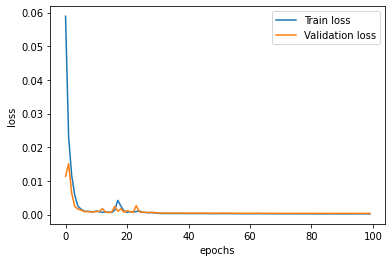

In [13]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

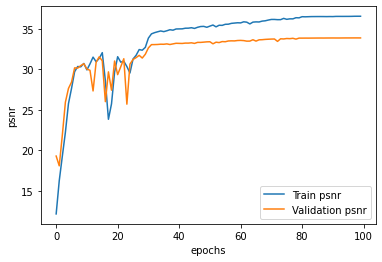

In [14]:
plt.plot(train_psnr, label = 'Train psnr')
plt.plot(val_psnr, label = 'Validation psnr')
plt.xlabel('epochs')
plt.ylabel('psnr')
plt.legend()
plt.show()

convert LR images to HR images: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


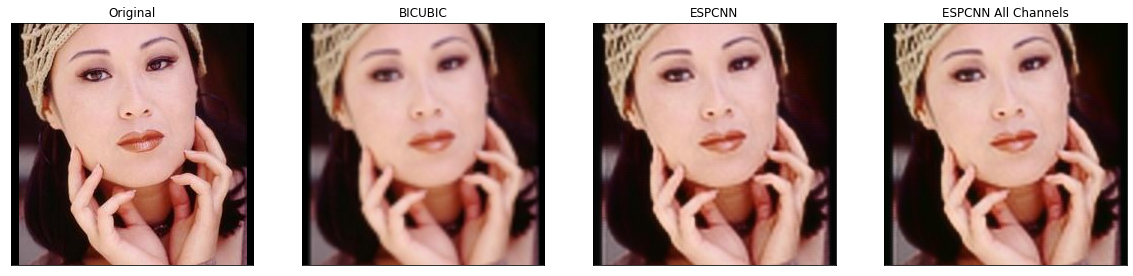

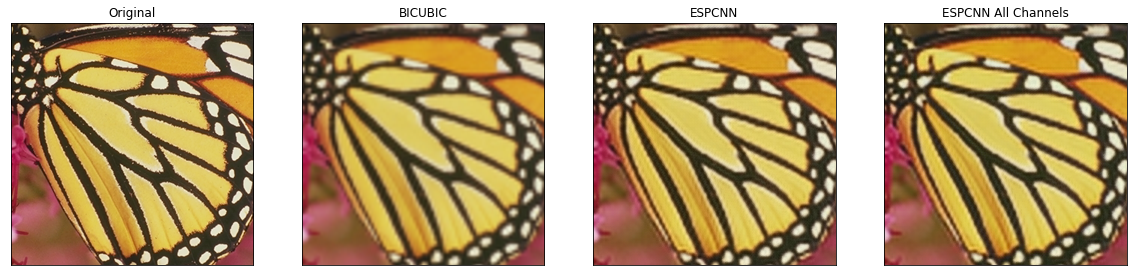

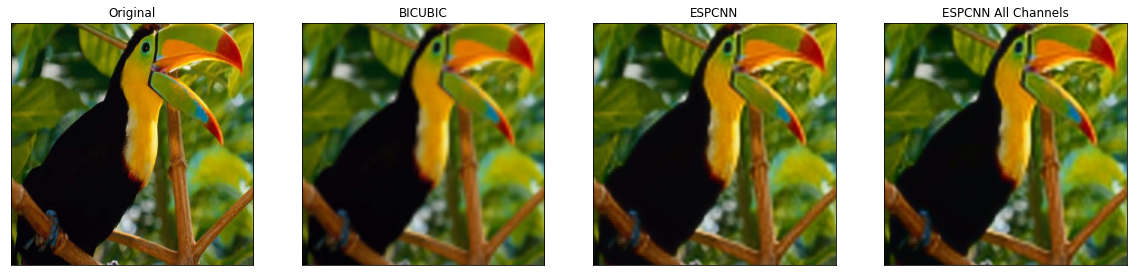

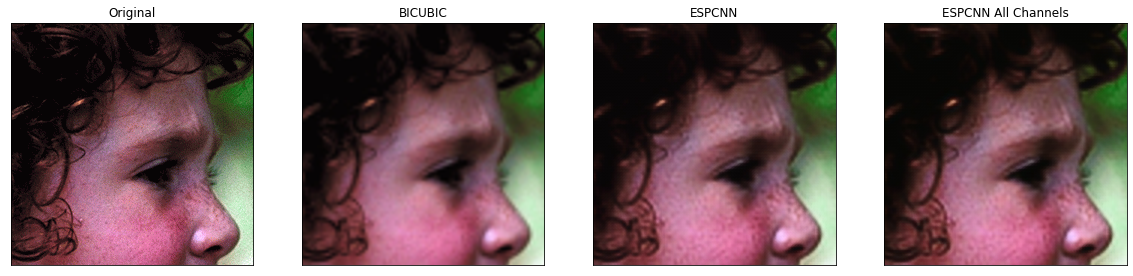

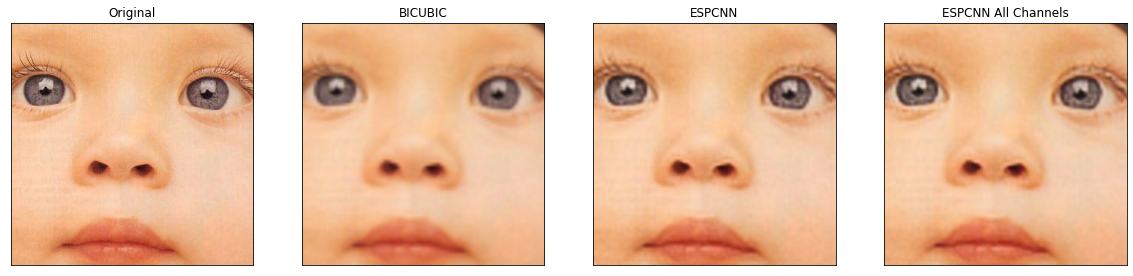

In [21]:
def shave(image, border):
    img = image[border: -border, border: -border]
    return img

path = 'data/Test/Set5/SRF_' + str(UPSCALE_FACTOR) + '/data/'
images_name = [x for x in listdir(path) if is_image_file(x)]

out_path = 'results/SRF_' + str(UPSCALE_FACTOR) + '/'

if not os.path.exists(out_path):
    os.makedirs(out_path)
for image_name in tqdm(images_name, desc='convert LR images to HR images'):

    ref = Image.open('data/Test/Set5/SRF_' + str(UPSCALE_FACTOR) + '/target/' + image_name)
    img = Image.open(path + image_name).convert('YCbCr')
    y, cb, cr = img.split()
    image = Variable(transforms.ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
    if torch.cuda.is_available():
        image = image.cuda()

    out = model_Y(image)
    out = out.cpu()
    out_img_y = out.data[0].numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    out_img.save(out_path + image_name)
    image = Variable(transforms.ToTensor()(cb)).view(1, -1, y.size[1], y.size[0])
    if torch.cuda.is_available():
        image = image.cuda()
    cb_out = model_Cb(image)
    image = Variable(transforms.ToTensor()(cr)).view(1, -1, y.size[1], y.size[0])
    if torch.cuda.is_available():
        image = image.cuda()
    cr_out = model_Cr(image)
    out_img_cb = cb_out.data[0].numpy()
    out_img_cb *= 255.0
    out_img_cb = out_img_cb.clip(0, 255)
    out_img_cb = Image.fromarray(np.uint8(out_img_cb[0]))
    out_img_cr = cr_out.data[0].numpy()
    out_img_cr *= 255.0
    out_img_cr = out_img_cr.clip(0, 255)
    out_img_cr = Image.fromarray(np.uint8(out_img_cr[0]))
    sup = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    
    w = ref.width
    h = ref.height
    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    axs[0].imshow(ref.crop((6,6,w - 6, h - 6)))
    axs[0].set_title('Original')
    axs[1].imshow(img.convert('RGB').resize((img.width * 3, img.height * 3), resample = Image.BICUBIC).crop((6,6,w-6,h-6)))
    axs[1].set_title('BICUBIC')
    #axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(out_img.crop((6,6,w - 6,h - 6)))
    axs[2].set_title('ESPCNN')
    #axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))
    axs[3].imshow(sup.crop((6,6,w-6,h-6)))
    axs[3].set_title('ESPCNN All Channels')

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    #print('Saving {}'.format(file))
    #fig.savefig('Output/{}.png'.format(os.path.splitext(file)[0])) 
    #plt.close()